In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ClassicalRegister,QuantumRegister, IfElseOp, Delay
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_bloch_vector
from qiskit_aer import AerSimulator
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
import numpy as np
from qiskit.quantum_info import Statevector, DensityMatrix, state_fidelity
import random
from qiskit.result.utils import marginal_counts
from qiskit import assemble


In [2]:
p_bitflip_cx = 0.1

bitflip_cx_error = pauli_error([
    ('II', 1 - p_bitflip_cx),   # no error
    ('IX', p_bitflip_cx / 2),   # flip target qubit
    ('XI', p_bitflip_cx / 2),   # flip control qubit
    # Optional: you could add ('XX', p), but only if your model wants that
])

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(bitflip_cx_error, ['cx'])

bitflip_error = pauli_error([('X', p_bitflip_cx), ('I', 1 - p_bitflip_cx)])
noise_model.add_all_qubit_quantum_error(bitflip_error, ['x'])

# Set up the simulator
backend_noise = AerSimulator(method='density_matrix', noise_model=noise_model)

In [3]:
#this code incorporates majority vote recovery method

q=QuantumRegister(3,'q')
c=ClassicalRegister(1,'c')
majority_vote_circuit=QuantumCircuit(q,c)

#encoding
majority_vote_circuit.cx(q[0],q[1])
majority_vote_circuit.cx(q[0],q[2])
majority_vote_circuit.barrier()

# #decoding
# majority_vote_circuit.cx(q[1],q[0])
# majority_vote_circuit.cx(q[2],q[0])
# majority_vote_circuit.barrier()

#apply tofolli gate
majority_vote_circuit.ccx(q[2],q[1],q[0])
majority_vote_circuit.barrier()

#measure
majority_vote_circuit.measure(q[0],c[0])
majority_vote_circuit.barrier()


majority_vote_circuit.save_density_matrix()


In [4]:
majority_vote_circuit.draw()


░ ┌───┐ ░ ┌─┐ ░  density_matrix 
q_0: ──■────■───░─┤ X ├─░─┤M├─░────────░────────
     ┌─┴─┐  │   ░ └─┬─┘ ░ └╥┘ ░        ░        
q_1: ┤ X ├──┼───░───■───░──╫──░────────░────────
     └───┘┌─┴─┐ ░   │   ░  ║  ░        ░        
q_2: ─────┤ X ├─░───■───░──╫──░────────░────────
          └───┘ ░       ░  ║  ░        ░        
c: 1/══════════════════════╩════════════════════
                           0

Fidelity to ideal |000>: 0.5286


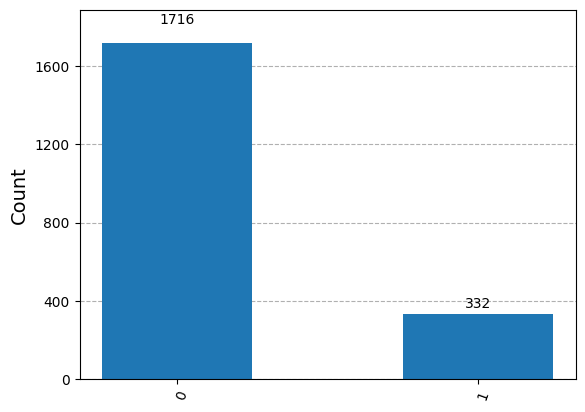

In [5]:
majority_vote_circuit_noise = transpile(
    majority_vote_circuit,
    backend=backend_noise,
    basis_gates=backend_noise.configuration().basis_gates
)

result = backend_noise.run(majority_vote_circuit_noise, shots=2048).result()

rho_noisy = result.data().get('density_matrix')
rho = DensityMatrix(rho_noisy)  # Already 3-qubit state

ideal_state = DensityMatrix.from_label('000')
fidelity = state_fidelity(rho, ideal_state)

print(f"Fidelity to ideal |000>: {fidelity:.4f}")

# Run the circuit
counts = result.get_counts()

# View the outcome
plot_histogram(counts)

In [6]:
#using ancillas method 1:
q2=QuantumRegister(3,'q')
a2=QuantumRegister(2,'a')#two ancillaries
c2=ClassicalRegister(3,'c')
#ca=ClassicalRegister(2,'ca')#ancilla classicical
syndrome_extraction_circuit=QuantumCircuit(q2,c2,a2)

#encoding
syndrome_extraction_circuit.cx(q2[0],q2[1])
syndrome_extraction_circuit.cx(q2[0],q2[2])
syndrome_extraction_circuit.barrier()

#ancilla checking
syndrome_extraction_circuit.cx(q2[0],a2[0])
syndrome_extraction_circuit.cx(q2[1],a2[0])
syndrome_extraction_circuit.cx(q2[1],a2[1])
syndrome_extraction_circuit.cx(q2[2],a2[1])
syndrome_extraction_circuit.barrier()

# #measure ancillas
# syndrome_extraction_circuit.measure(a2[0], ca[0])
# syndrome_extraction_circuit.measure(a2[1], ca[1])
# syndrome_extraction_circuit.barrier()


# with syndrome_extraction_circuit.switch(ca) as case:
#     with case(0b10):
#         syndrome_extraction_circuit.x(q2[2])
#     with case(0b11):
#         syndrome_extraction_circuit.x(q2[1])
#     with case(0b01):
#         syndrome_extraction_circuit.x(q2[0])

#LOGICAL OPERATIONS FOR FLIPPING PROPER BIT

#11
#Q1=A2 AND A1
syndrome_extraction_circuit.ccx(a2[0],a2[1],q2[1])
syndrome_extraction_circuit.barrier()

#01
#Q0=A0! AND A1
syndrome_extraction_circuit.x(a2[0])#not ca[0]
syndrome_extraction_circuit.ccx(a2[0],a2[1],q2[0])
syndrome_extraction_circuit.barrier()

#10
#Q2=A0 && !A1
syndrome_extraction_circuit.x(a2[0])#ca[0]
syndrome_extraction_circuit.x(a2[1])#not ca[1]
syndrome_extraction_circuit.ccx(a2[0],a2[1],q2[2])
syndrome_extraction_circuit.barrier()


#decoding
syndrome_extraction_circuit.cx(q2[1],q2[0])
syndrome_extraction_circuit.cx(q2[2],q2[0])
syndrome_extraction_circuit.barrier()


#q2[0] actually needed ot be measured but just to be sure
syndrome_extraction_circuit.measure(q2,c2)

syndrome_extraction_circuit.save_density_matrix()


In [7]:
syndrome_extraction_circuit.draw()

░                      ░       ░      ┌───┐ ░            ░ »
q_0: ──■────■───░───■──────────────────░───────░──────┤ X ├─░────────────░─»
     ┌─┴─┐  │   ░   │                  ░ ┌───┐ ░      └─┬─┘ ░            ░ »
q_1: ┤ X ├──┼───░───┼────■────■────────░─┤ X ├─░────────┼───░────────────░─»
     └───┘┌─┴─┐ ░   │    │    │        ░ └─┬─┘ ░        │   ░      ┌───┐ ░ »
q_2: ─────┤ X ├─░───┼────┼────┼────■───░───┼───░────────┼───░──────┤ X ├─░─»
          └───┘ ░ ┌─┴─┐┌─┴─┐  │    │   ░   │   ░ ┌───┐  │   ░ ┌───┐└─┬─┘ ░ »
a_0: ───────────░─┤ X ├┤ X ├──┼────┼───░───■───░─┤ X ├──■───░─┤ X ├──■───░─»
                ░ └───┘└───┘┌─┴─┐┌─┴─┐ ░   │   ░ └───┘  │   ░ ├───┤  │   ░ »
a_1: ───────────░───────────┤ X ├┤ X ├─░───■───░────────■───░─┤ X ├──■───░─»
                ░           └───┘└───┘ ░       ░            ░ └───┘      ░ »
c: 3/══════════════════════════════════════════════════════════════════════»
                                                                           »
«     ┌───┐┌───┐ ░ ┌─┐       density_matrix 
«q_0: ┤ X ├┤ X ├─░─┤M├─────────────░────────
«     └─┬─┘└─┬─┘ ░ └╥┘┌─┐          ░        
«q_1: ──■────┼───░──╫─┤M├──────────░────────
«            │   ░  ║ └╥┘┌─┐       ░        
«q_2: ───────■───░──╫──╫─┤M├───────░────────
«                ░  ║  ║ └╥┘       ░        
«a_0: ───────────░──╫──╫──╫────────░────────
«                ░  ║  ║  ║        ░        
«a_1: ───────────░──╫──╫──╫────────░────────
«                ░  ║  ║  ║        ░        
«c: 3/══════════════╩══╩══╩═════════════════
«                   0  1  2

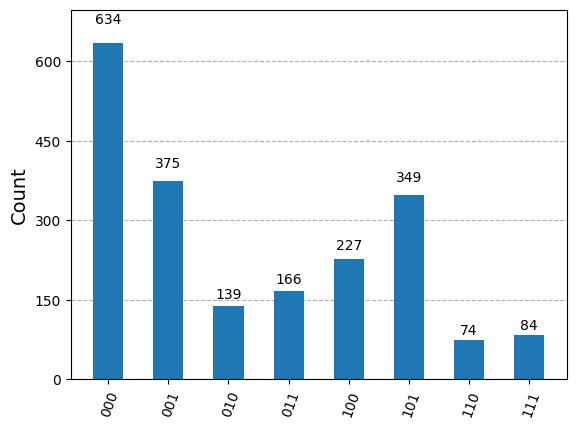

In [8]:
syndrome_extraction_circuit_noise = transpile(
    syndrome_extraction_circuit,
    backend=backend_noise,
    basis_gates=backend_noise.configuration().basis_gates
)

# Run the circuit
result = backend_noise.run(syndrome_extraction_circuit_noise, shots=2048).result()
counts = result.get_counts()

# View the outcome
marginalized = marginal_counts(counts, indices=[0,1,2])#remove ancilla values
plot_histogram(marginalized)





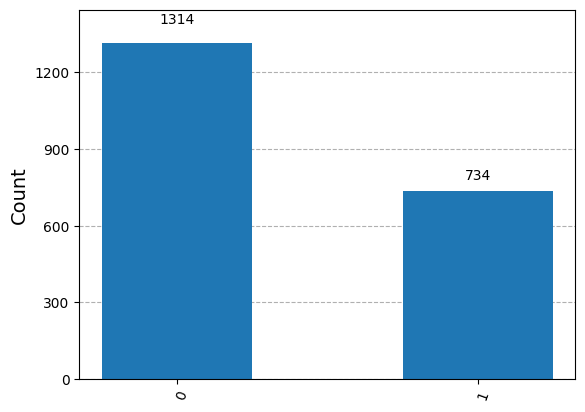

In [9]:
marginalized = marginal_counts(counts, indices=[2])#remove ancilla values
plot_histogram(marginalized)


In [10]:
#THE ABOVE APPROACH IS FLAWED BECAUSE IT DOES NOT PROPERLY EMULATE NOISE.
#IN IT, ALL GATES HAVE A CHANCE OF NOISE WHEN REALLY THE CIRCUIT SHOULD BE MOSTLY NOISY DURING
#TRANSMISSION. ONCE RECEIVED ODDS OF NOISE SHOULD BE LOWERED.
#BECAUSE OF THIS THERE ARE BIT FLIPS OCCURRING ON THE CORRECTION LOGIC WHICH DEFEATS THE WHOLE PURPOSE

In [11]:
#BELOW IS A IMPLEMENTATION WITH NOISE ONLY DURING TRANSMISSION

In [12]:
q = QuantumRegister(3, 'q')
encoding_circuit = QuantumCircuit(q)

# Encode without any noise
encoding_circuit.cx(q[0], q[1])
encoding_circuit.cx(q[0], q[2])
encoding_circuit.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

In [13]:
#use delay to simulate transmission
noise_phase_circuit = QuantumCircuit(q)
noise_phase_circuit.delay(100, q[0])
noise_phase_circuit.delay(100, q[1])
noise_phase_circuit.delay(100, q[2])
noise_phase_circuit.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

In [14]:
a = QuantumRegister(2, 'a')
c = ClassicalRegister(3, 'c')
correction_circuit = QuantumCircuit(q, a, c)



#ancilla checking
correction_circuit.cx(q[0],a[0])
correction_circuit.cx(q[1],a[0])
correction_circuit.cx(q[1],a[1])
correction_circuit.cx(q[2],a[1])
correction_circuit.barrier()

#LOGICAL OPERATIONS FOR FLIPPING PROPER BIT

#11
#Q1=A2 AND A1
correction_circuit.ccx(a[0],a[1],q[1])
correction_circuit.barrier()

#01
#Q0=A0! AND A1
correction_circuit.x(a[0])#not ca[0]
correction_circuit.ccx(a[0],a[1],q[0])
correction_circuit.barrier()

#10
#Q2=A0 && !A1
correction_circuit.x(a[0])#ca[0]
correction_circuit.x(a[1])#not ca[1]
correction_circuit.ccx(a[0],a[1],q[2])
correction_circuit.barrier()

#decoding
correction_circuit.cx(q2[1],q2[0])
correction_circuit.cx(q2[2],q2[0])
correction_circuit.barrier()


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=5, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2), Qubit(QuantumRegister(2, 'a'), 0), Qubit(QuantumRegister(2, 'a'), 1)), clbits=())

In [15]:
# Assuming all 3 circuits use the same QuantumRegister objects
full_circuit = QuantumCircuit(q, c, a)  # same registers across all

full_circuit.compose(encoding_circuit, inplace=True)
full_circuit.compose(noise_phase_circuit, inplace=True)
full_circuit.compose(correction_circuit, inplace=True)
full_circuit.measure(q,c)

full_circuit.draw()




░ ┌────────────────┐ ░                      ░       ░      »
q_0: ──■────■───░─┤ Delay(100[dt]) ├─░───■──────────────────░───────░──────»
     ┌─┴─┐  │   ░ ├────────────────┤ ░   │                  ░ ┌───┐ ░      »
q_1: ┤ X ├──┼───░─┤ Delay(100[dt]) ├─░───┼────■────■────────░─┤ X ├─░──────»
     └───┘┌─┴─┐ ░ ├────────────────┤ ░   │    │    │        ░ └─┬─┘ ░      »
q_2: ─────┤ X ├─░─┤ Delay(100[dt]) ├─░───┼────┼────┼────■───░───┼───░──────»
          └───┘ ░ └────────────────┘ ░ ┌─┴─┐┌─┴─┐  │    │   ░   │   ░ ┌───┐»
a_0: ──────────────────────────────────┤ X ├┤ X ├──┼────┼───░───■───░─┤ X ├»
                                       └───┘└───┘┌─┴─┐┌─┴─┐ ░   │   ░ └───┘»
a_1: ────────────────────────────────────────────┤ X ├┤ X ├─░───■───░──────»
                                                 └───┘└───┘ ░       ░      »
c: 3/══════════════════════════════════════════════════════════════════════»
                                                                           »
«     ┌───┐ ░            ░ ┌───┐┌───┐ ░ ┌─┐      
«q_0: ┤ X ├─░────────────░─┤ X ├┤ X ├─░─┤M├──────
«     └─┬─┘ ░            ░ └─┬─┘└─┬─┘ ░ └╥┘┌─┐   
«q_1: ──┼───░────────────░───■────┼───░──╫─┤M├───
«       │   ░      ┌───┐ ░        │   ░  ║ └╥┘┌─┐
«q_2: ──┼───░──────┤ X ├─░────────■───░──╫──╫─┤M├
«       │   ░ ┌───┐└─┬─┘ ░            ░  ║  ║ └╥┘
«a_0: ──■───░─┤ X ├──■───░────────────░──╫──╫──╫─
«       │   ░ ├───┤  │   ░            ░  ║  ║  ║ 
«a_1: ──■───░─┤ X ├──■───░────────────░──╫──╫──╫─
«           ░ └───┘      ░            ░  ║  ║  ║ 
«c: 3/═══════════════════════════════════╩══╩══╩═
«                                        0  1  2

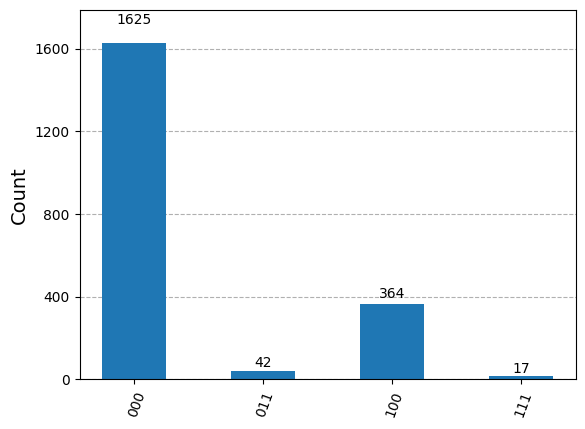

In [16]:
#REDEFINE NOISE FOR IDENTITY GATES ONLY IE TRANSMISSION BETWEEN TWO USERS

p_bitflip = 0.1  # or whatever rate you want for transmission noise

#define a bit-flip noise model for the identity gate
bitflip_error = pauli_error([
    ('X', p_bitflip),         # bit-flip occurs
    ('I', 1 - p_bitflip)      # no error
])

# Build the noise model
noise_model2 = NoiseModel()
noise_model2.add_all_qubit_quantum_error(bitflip_error, ['delay'])
backend_noise2 = AerSimulator(method='density_matrix', noise_model=noise_model2)

transpiled = transpile(full_circuit, backend=backend_noise2)
result = backend_noise2.run(transpiled, shots=2048).result()
counts = result.get_counts()
marginalized = marginal_counts(counts, indices=[0,1,2])#remove ancilla values
plot_histogram(marginalized)

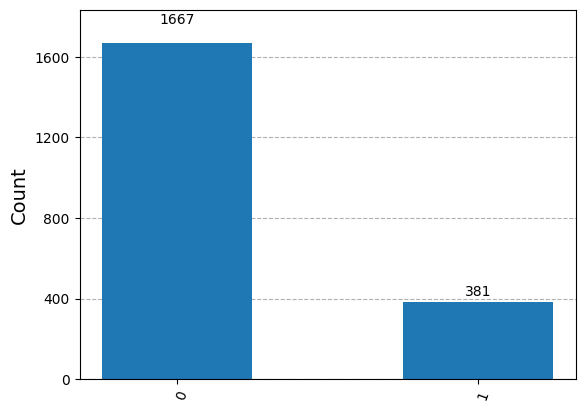

In [17]:
marginalized = marginal_counts(counts, indices=[2])#remove ancilla values
plot_histogram(marginalized)


In [19]:
#3bits per run
print("Chance of bitflip: ", 3*p_bitflip)
correct = sum(v for k, v in counts.items() if k[0] == '0')
incorrect = sum(v for k, v in counts.items() if k[0] == '1')

print("Ratio of correction: ", correct, "/", (correct + incorrect), ": ",100* correct/(correct+incorrect), " percent")

Chance of bitflip:  0.30000000000000004
Ratio of correction:  1667 / 2048 :  81.396484375  percent
